In [1]:
!pip install qiskit qiskit_aer
!pip install pylatexenc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Grover's Search Algorithm using Qiskit 2.x

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
# Universal Visualization Helper (mpl fallback)
def show_circuit(qc):
    """Display circuit using 'mpl' if available, else text fallback."""
    try:
        fig = qc.draw(output='mpl')
        fig.savefig("circuit.png")
        display(Image("circuit.png"))
    except Exception:
        print(qc.draw('text'))


#  Oracle
def oracle(qc, n, marked_state):
    """Constructs the oracle for the marked state."""
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # multi-controlled X
    qc.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)


#  Diffuser
def diffuser(qc, n):
    """Implements the Grover diffuser."""
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))

#  Grover’s Search Builder
def grover_search(marked_state, iterations=1):
    """Builds Grover's search circuit for a given marked state."""
    n = len(marked_state)
    qc = QuantumCircuit(n, n)
    qc.h(range(n))  # create equal superposition

    for _ in range(iterations):
        oracle(qc, n, marked_state)
        diffuser(qc, n)

    qc.measure(range(n), range(n))
    return qc


#  Runner
def run_grover(qc):
    """Execute and display results with histogram."""
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=1024).result()
    counts = result.get_counts()

    display(plot_histogram(counts))
    print("Measurement results:", counts)
    print("Most probable state:", max(counts, key=counts.get))



Searching for marked state: 001


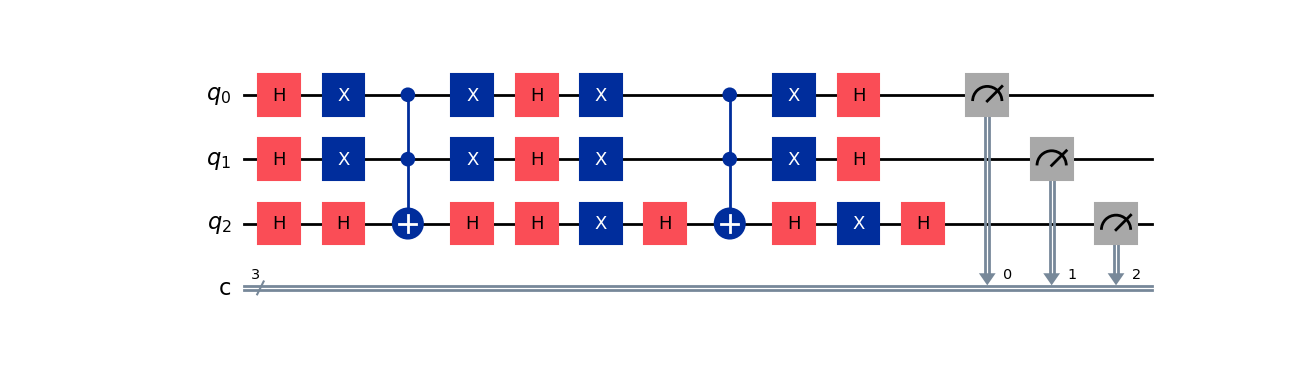

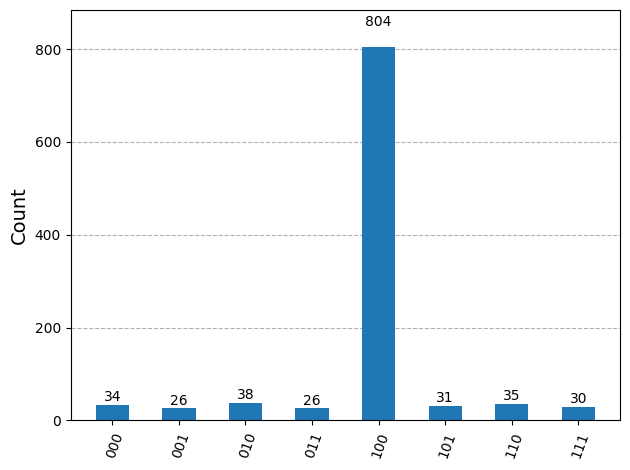

Measurement results: {'001': 26, '101': 31, '000': 34, '010': 38, '111': 30, '011': 26, '110': 35, '100': 804}
Most probable state: 100

Searching for marked state: 111


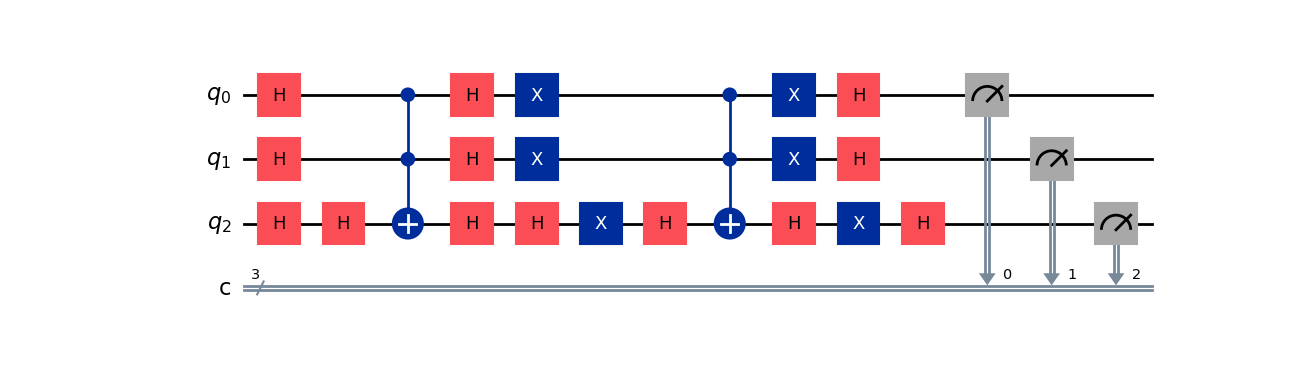

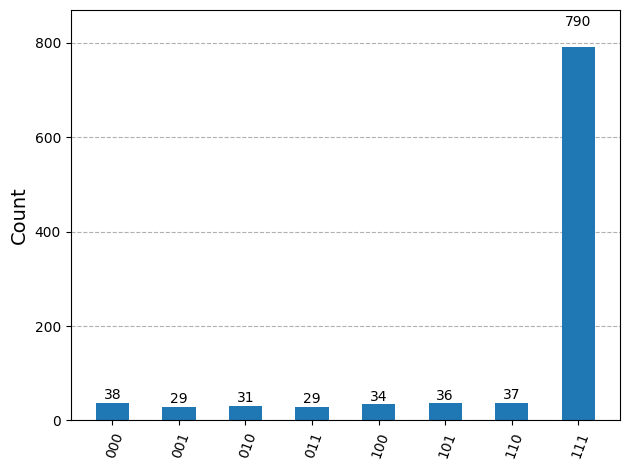

Measurement results: {'101': 36, '001': 29, '000': 38, '010': 31, '110': 37, '100': 34, '011': 29, '111': 790}
Most probable state: 111

Searching for marked state: 010


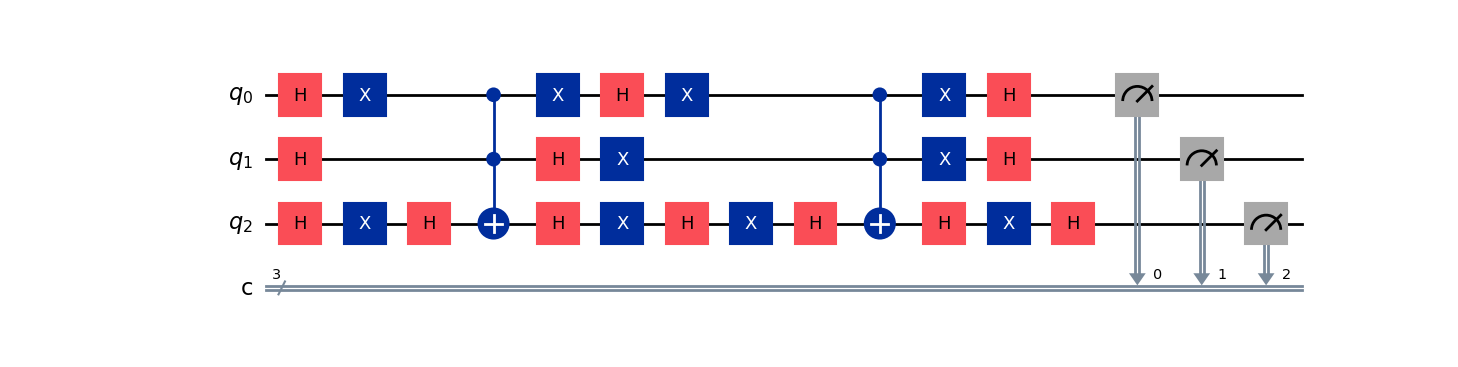

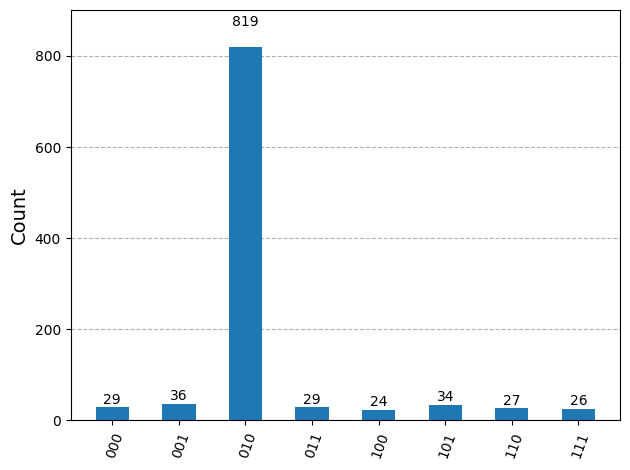

Measurement results: {'100': 24, '110': 27, '001': 36, '101': 34, '011': 29, '111': 26, '000': 29, '010': 819}
Most probable state: 010


In [4]:
for marked_state in ["001", "111", "010"]:
    print(f"\nSearching for marked state: {marked_state}")
    qc = grover_search(marked_state)
    show_circuit(qc)
    run_grover(qc)



Searching for marked state in 4-qubit system: 1010


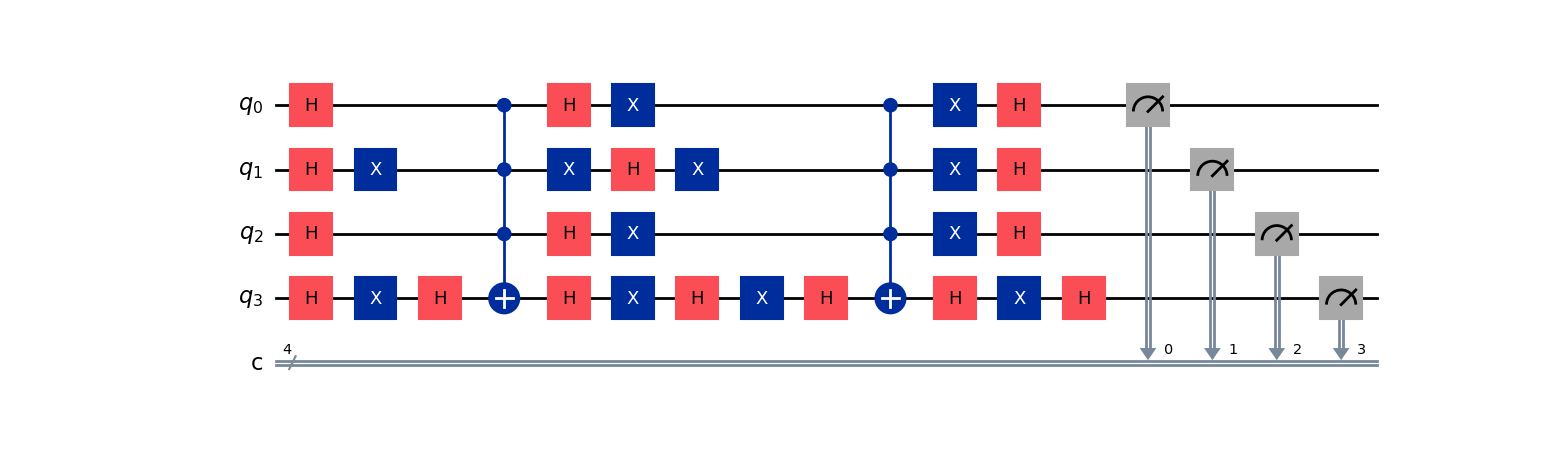

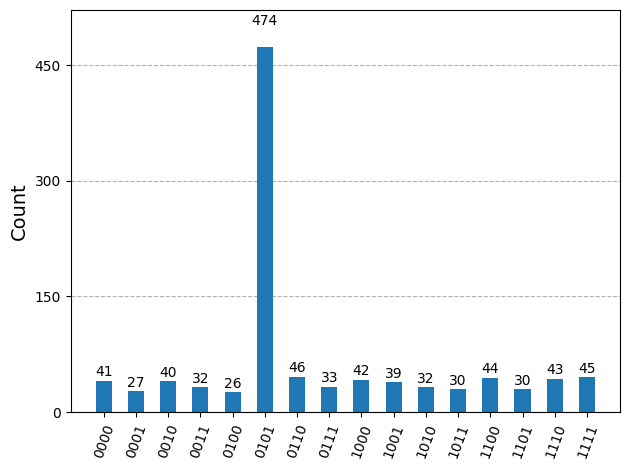

Measurement results: {'1101': 30, '1111': 45, '1110': 43, '0100': 26, '1100': 44, '0101': 474, '1001': 39, '1011': 30, '0011': 32, '0111': 33, '1000': 42, '0110': 46, '0000': 41, '0010': 40, '1010': 32, '0001': 27}
Most probable state: 0101


In [5]:
#Extend Grover’s algorithm to 4 qubits
marked_state = "1010"
print(f"\nSearching for marked state in 4-qubit system: {marked_state}")
qc = grover_search(marked_state)
show_circuit(qc)
run_grover(qc)




Multiple Iterations for marked state: 101


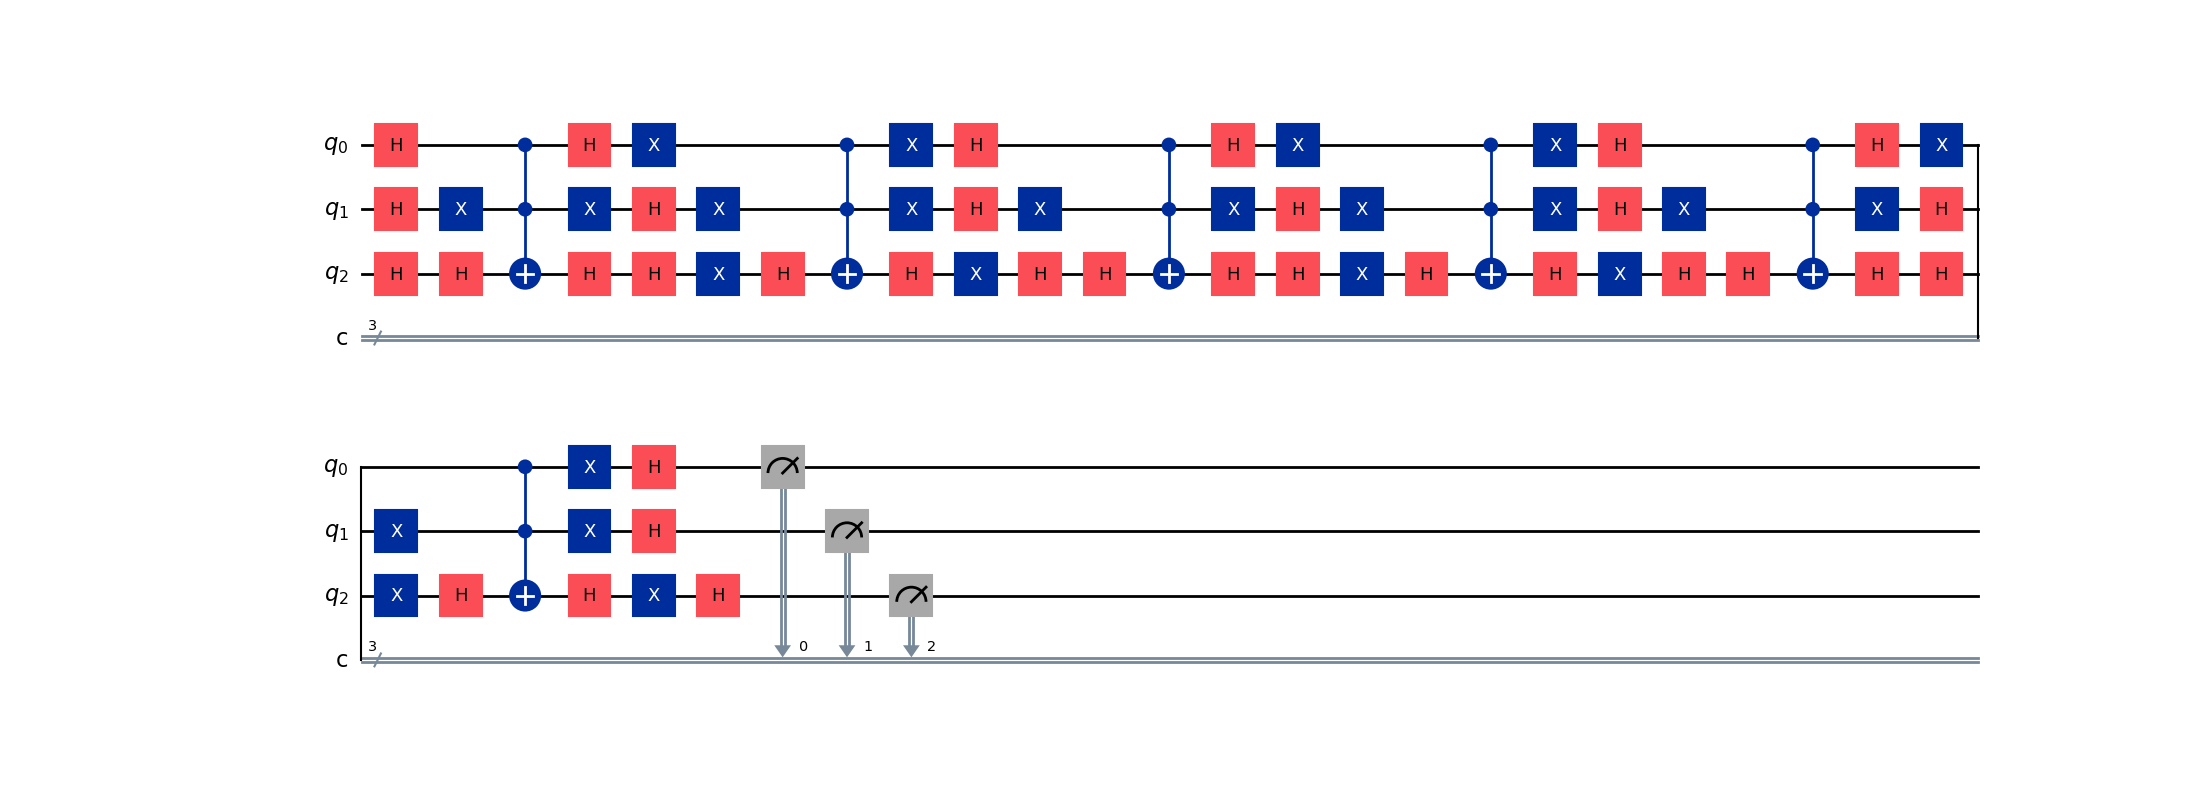

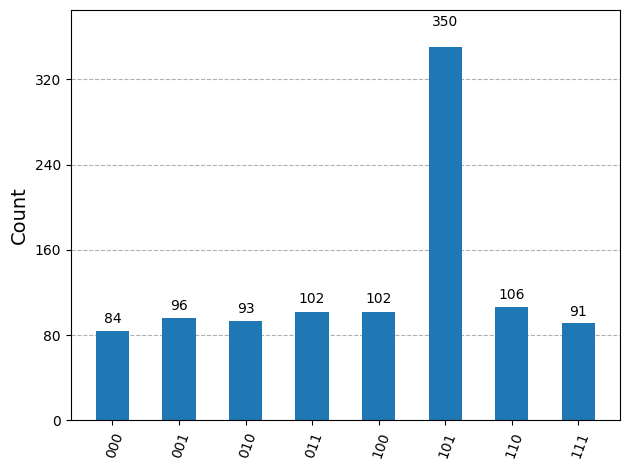

Measurement results: {'100': 102, '001': 96, '110': 106, '101': 350, '000': 84, '010': 93, '011': 102, '111': 91}
Most probable state: 101


In [6]:
#Apply Oracle + Diffuser multiple times to amplify amplitude
marked_state = "101"
print(f"\nMultiple Iterations for marked state: {marked_state}")
qc = grover_search(marked_state, iterations=3)
show_circuit(qc)
run_grover(qc)


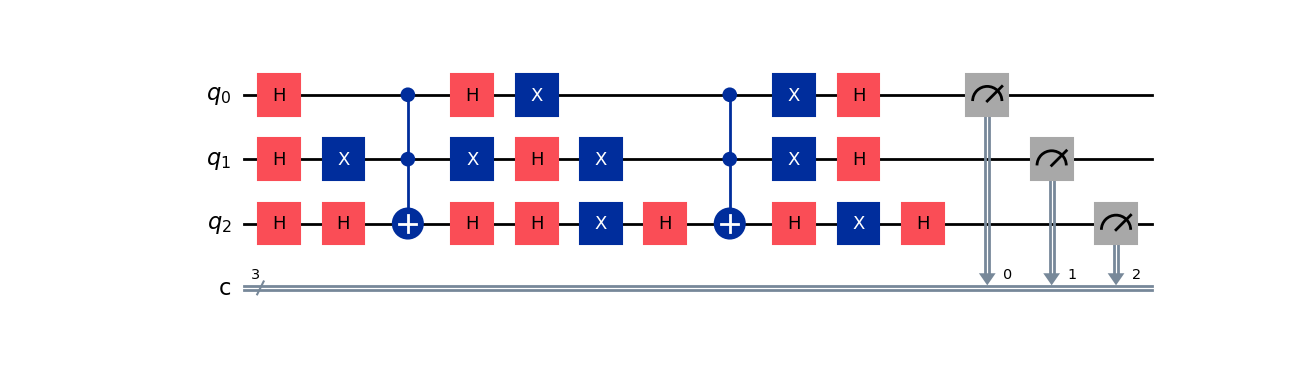

In [7]:
marked_state = "101"
qc = grover_search(marked_state)
show_circuit(qc)


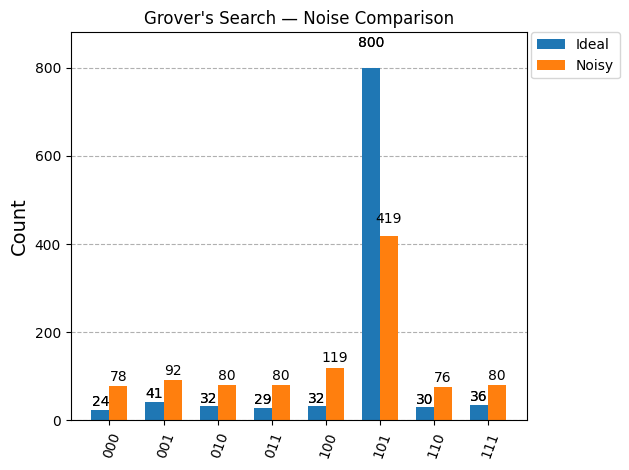

In [8]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Define noise model
noise_model = NoiseModel()
depol1 = depolarizing_error(0.02, 1)
depol2 = depolarizing_error(0.05, 2)
noise_model.add_all_qubit_quantum_error(depol1, ['h', 'x'])
noise_model.add_all_qubit_quantum_error(depol2, ['cx'])

# Run ideal vs noisy
marked_state = "101"
qc = grover_search(marked_state)

ideal_sim = AerSimulator()
noisy_sim = AerSimulator(noise_model=noise_model)

tqc_ideal = transpile(qc, ideal_sim)
tqc_noisy = transpile(qc, noisy_sim)

res_ideal = ideal_sim.run(tqc_ideal, shots=1024).result()
res_noisy = noisy_sim.run(tqc_noisy, shots=1024).result()

counts_ideal = res_ideal.get_counts()
counts_noisy = res_noisy.get_counts()

display(plot_histogram([counts_ideal, counts_noisy],
                       legend=['Ideal', 'Noisy'],
                       title="Grover's Search — Noise Comparison"))
